In [1]:
# Standard library
from ftplib import FTP
import glob
import os
from zipfile import ZipFile

# Third party
import rasterio as rio
import numpy as np
import xesmf as xe
import matplotlib.pyplot as plt

```python
# Download PRISM data
root = os.getcwd()
ftp = FTP("prism.oregonstate.edu")
ftp.login()
ftp.cwd("/daily/tmax/2016")
remote_fn = ftp.nlst()[0]
local_fn = os.path.join(root, remote_fn)
with open(local_fn, "wb") as file:
    ftp.retrbinary(f"RETR {remote_fn}", file.write)
with ZipFile(local_fn) as myzip:
    myzip.extractall()
os.unlink(local_fn)
ftp.quit()
```

Some useful properties.

- `dataset.bounds`: prints the spatial bounds of the data
- `dataset.transform`: mulitply by array indices `(x,y)` to get corresponding longitude and latitude
- `dataset.crs`: gets the coordinate reference system of the data

Some useful methods.
- `dataset.xy(y, x)`: like multiplying by `dataset.transform`

At least for PRISM, I prefer to use `dataset.transform` since it more closely matches the bounds.

In [2]:
dataset = rio.open("PRISM_tmax_stable_4kmD2_20160101_bil.bil")

In [3]:
print(dataset.width, dataset.height)

1405 621


In [4]:
# latitudes are fine as-is
# for longitude, to match era5, we have to convert
# https://gis.stackexchange.com/a/201793

lats = np.empty(dataset.height, dtype=float)
lons = np.empty(dataset.width, dtype=float)

for i in range(dataset.height):
    lats[i] = (dataset.transform * (dataset.width // 2, i))[1]
    
for i in range(dataset.width):
    lons[i] = (dataset.transform * (i, dataset.height // 2))[0] % 360

In [26]:
arr = dataset.read(1)

In [27]:
# in PRISM, -9999 indicates no data was collected for that location
prism_mask = (arr != -9999).astype(int)

In [7]:
# At the equator, 1km ~= 0.008 degrees
# PRISM grid cells are ~4x4 km (~0.032 degrees)
# This is too small, so let's regrid PRISM data
target_res = 0.75 # degrees
scaling_factor = 0.032 / target_res
target_width = round(dataset.width * scaling_factor)
target_height = round(dataset.height * scaling_factor)

print(f"Target width: {target_width}")
print(f"Target height: {target_height}")

Target width: 60
Target height: 26


In [8]:
grid_in = {"lon": lons, "lat": lats}
grid_out = {
    "lon": np.linspace(lons.min(), lons.max(), target_width),
    "lat": np.linspace(lats.min(), lats.max(), target_height)
}

In [9]:
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_621x1405_26x60.nc 
Reuse pre-computed weights? False 
Input grid shape:           (621, 1405) 
Output grid shape:          (26, 60) 
Periodic in longitude?      False

In [10]:
masked_arr = np.where(prism_mask, arr, np.nan)

In [11]:
arr_out = regridder(masked_arr)

In [12]:
first_row = np.empty(arr_out.shape[1])
first_row[:] = np.nan
fixed_arr = np.vstack((first_row, arr_out[1:]))

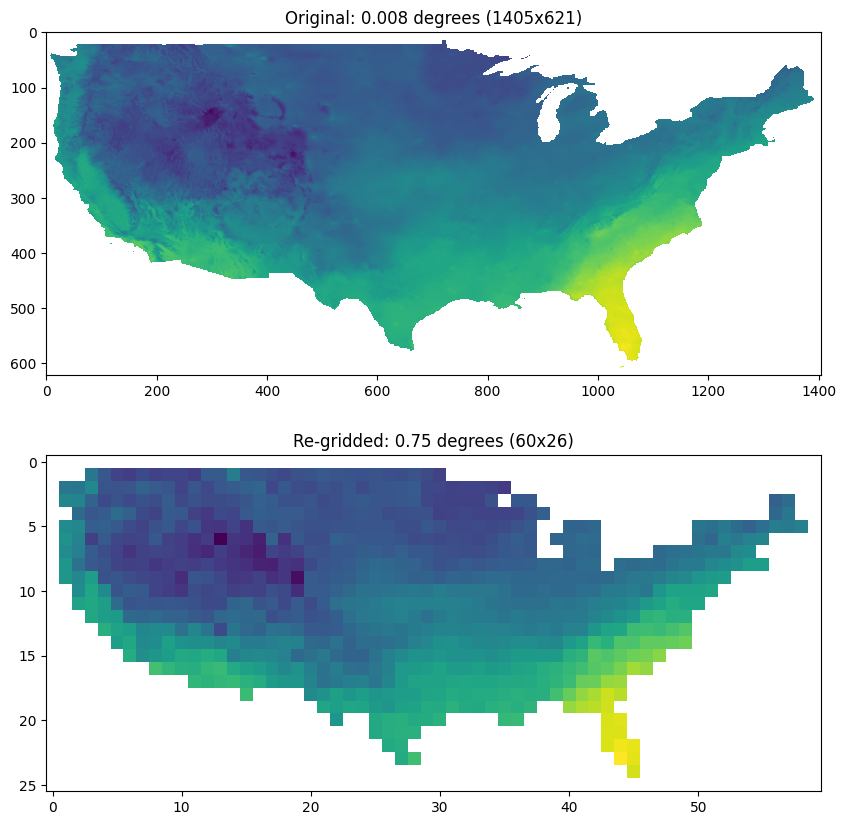

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))

ax[0].imshow(masked_arr)
ax[0].set_title(f"Original: 0.008 degrees ({dataset.width}x{dataset.height})")

ax[1].imshow(fixed_arr[::-1])
ax[1].set_title(f"Re-gridded: {target_res} degrees ({target_width}x{target_height})")

plt.show()

In [15]:
# latitude and longitude bounds of PRISM
bottom = lats.min()
top = lats.max()
left = lons.min()
right = lons.max()
print(bottom, top)
print(left, right)

24.104166666645753 49.93749999999975
234.97916666666663 293.47916666671347


# ERA5

In [16]:
root_dir = os.environ["ERA5_2DEG"]
inplist = glob.glob(os.path.join(root_dir, "test", "*.npz"))[:-1]
lats = np.load(os.path.join(root_dir, "lat.npy"))
lons = np.load(os.path.join(root_dir, "lon.npy"))

In [28]:
inp = np.load(inplist[0])
arr = inp["2m_temperature"][0,0]
mask = np.zeros_like(arr)

In [29]:
def get_yx(lat, lon):
    y = np.searchsorted(lats, lat)
    x = np.searchsorted(lons, lon)
    return y, x

In [30]:
for lat in np.linspace(bottom, top):
    for lon in np.linspace(left, right):
        y, x = get_yx(lat, lon)
        mask[y,x] = 1

masked_arr = mask * arr

In [31]:
y, x = get_yx(bottom, left)
yy, xx = get_yx(top, right)
cropped_arr = arr[y:yy,x:xx]
print(cropped_arr.shape)

(9, 21)


In [33]:
vmin = arr.min()
vmax = arr.max()

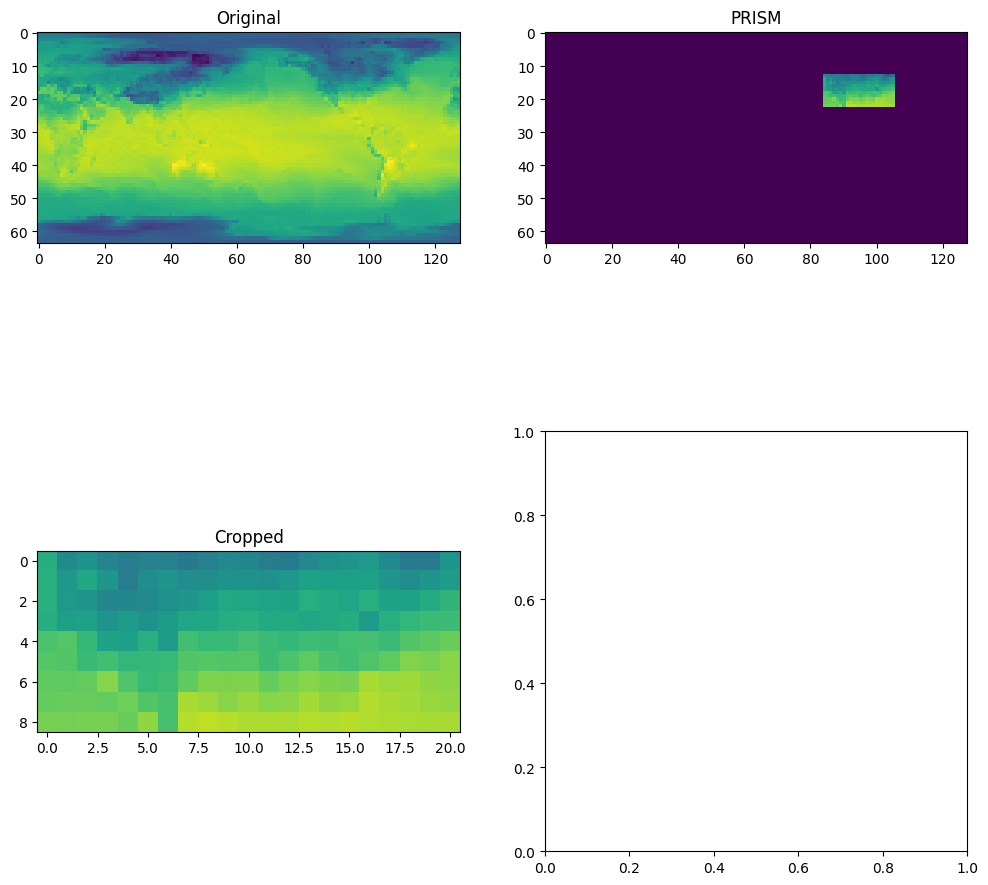

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))

ax[0,0].imshow(arr[::-1], vmin=vmin, vmax=vmax)
ax[0,0].set_title("Original")

ax[0,1].imshow(masked_arr[::-1], vmin=vmin, vmax=vmax)
ax[0,1].set_title("PRISM")

ax[1,0].imshow(cropped_arr[::-1], vmin=vmin, vmax=vmax)
ax[1,0].set_title("Cropped")

plt.show()

In [37]:
target_mask = np.where(np.isnan(fixed_arr), 0, 1)
target_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [38]:
target_mask.shape

(26, 60)